In [15]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import math as m
 
def rs(f1, f2, a):
    if (a > 0):
        return a * f1
    else:
        return a * f2
    
def minmod(a, b):
    return np.where((a*b > 0), np.where(((abs(a) <= abs(b)) & (a*b > 0)), a, b), 0)    
    

def minmod2(a, b):
    if ((abs(a) <= abs(b)) & (a*b > 0)):
        return a
    elif (a*b > 0):
        return b
    else:
        return 0

def maxmod(a, b):
    return np.where((a*b > 0), np.where(((abs(a) >= abs(b)) & (a*b > 0)), a, b), 0)

def minmod_lim(u):
    return minmod(u[1:-1] - u[:-2], u[2:] - u[1:-1])

def superbee(u):
    return maxmod(minmod(u[2:] - u[1:-1], 2*(u[1:-1] - u[:-2])),
                             minmod(2*(u[2:] - u[1:-1]), u[1:-1] - u[:-2]))

def F_m(vx, vy, vz, T, n, Mol):
    Rg = 8.3144598 / Mol
    return n * ((1. / (2. * np.pi * Rg * T)) ** (3. / 2.)) * (
        np.exp(-((vx)**2 + (vy)**2 + (vz)**2) / (2. * Rg * T))
        )

def J(f, vmax, N):
    #fundamental constants
    Na = 6.02214129e+23
    kB = 1.381e-23 # J * K
    
    #gas parameters
    Mol = 32e-3 # kg
    Rg = 8.3144598  / Mol  # J / (mol * K) 
    m = 32e-3 / Na # kg
    
    Pr = 2. / 3.
    C = 127.
    T_0 = 292.25
    mu_0 = 20.18

    #vmax = np.sqrt(2 * Rg * T) * 4
    #L = 21
    
    h = 2. * vmax / N
    vx_ = np.linspace(-vmax+h/2, vmax-h/2, N)

    vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')

    assert np.all(vx[:,0,0] == vx_)
    assert np.all(vy[0,:,0] == vx_)
    assert np.all(vz[0,0,:] == vx_)

    n = (h ** 3) * np.sum(f)

    ux = (1. / n) * np.sum(vx * f)
    uy = (1. / n) * np.sum(vy * f)
    uz = (1. / n) * np.sum(vz * f)

    T = (2. / (3. * m * n * Rg)) * ((1. / 2.) * m * (h ** 3) * np.sum((vx*vx + vy*vy + vz*vz) * f)
                                    - (1. / 2.) * m * n * (ux*ux + uy*uy + uz*uz))

    Vx = vx - ux
    Vy = vy - uy
    Vz = vz - uz

    qx = (1. / 2.) * m * (h ** 3) * np.sum(Vx * (Vx*Vx + Vy*Vy + Vz*Vz) * f)
    qy = (1. / 2.) * m * (h ** 3) * np.sum(Vy * (Vx*Vx + Vy*Vy + Vz*Vz) * f)
    qz = (1. / 2.) * m * (h ** 3) * np.sum(Vz * (Vx*Vx + Vy*Vy + Vz*Vz) * f)

    rho = m * n

    p = rho * Rg * T

    (cx, cy, cz) = (Vx, Vy, Vz) / ((2. * Rg * T) ** (1. / 2.))

    Sx = (1. / n) * (h ** 3) * np.sum(cx * (cx*cx + cy*cy + cz*cz) * f)
    Sy = (1. / n) * (h ** 3) * np.sum(cy * (cx*cx + cy*cy + cz*cz) * f)
    Sz = (1. / n) * (h ** 3) * np.sum(cz * (cx*cx + cy*cy + cz*cz) * f)


    mu = mu_0 * ((T_0 + C) / (T + C)) * ((T / T_0) ** (3. / 2.))


    f_plus = F_m(Vx, Vy, Vz, T, n, Mol) * (1. + (4. / 5.) * (1. - Pr) * (cx*Sx + cy*Sy + cz*Sz) * 
                                      (cx*cx + cy*cy + cz*cz - (5. / 2.)))

    J = (p / mu) * (f_plus - f)

    return J

In [16]:
def solver(f_0, f_l, xl, xr, L, Tau, CFL, a, b, vmax, N):
    
    h = (xr - xl) / L 
    tau = h * CFL / a
    
    x = np.linspace(xl+h/2, xr-h/2, L)
    
    t = 0.
    
    hv = 2. * vmax / N
    vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
    vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')
    
    # initial condition 
    f = f_0
    slope = np.zeros((L, N, N, N))
    tmp = np.zeros((L, N, N, N))
    fl = np.zeros((L+1, N, N, N))
    fr = np.zeros((L+1, N, N, N))
    Flow = np.zeros((L+1, N, N, N))
    RHS = np.zeros((L, N, N, N))
    
    while(t < Tau):
        t += tau
        # boundary condition
        fl[0, :, :, :] = f_l(t)
        fr[L, :, :, :] = 0
        # reconstruction
        # compute slopes
        
        for i in range(1, L-1):
            slope[i, :, :, :] = (1. / h) * minmod(f[i, :, :, :] - f[i-1, :, :, :], f[i+1, :, :, :] - f[i, :, :, :])
            
        for i in range(L):
            fr[i, :, :, :] = f[i, :, :, :] - (h / 2) * slope[i, :, :, :]
        
        for i in range(1, L+1):
            fl[i, :, :, :] = f[i-1, :, :, :] + (h / 2) * slope[i-1, :, :, :]
        
        # riemann solver - compute fluxes
        for i in range(L+1):
            Flow[i, :, :, :] = rs(fl[i, :, :, :], fr[i, :, :, :], a)
            
        # compute RHS
        for i in range(L):
            RHS[i, :, :, :] = (- Flow[i+1, :, :, :] + Flow[i, :, :, :]) / h - J(f[i, :, :, :], 1500, N)

        # update values
        tmp[0, :, :, :] = f_l(t)
        for i in range(1, L):
            tmp[i, :, :, :] = f[i, :, :, :] + tau * RHS[i, :, :, :]
            
        u = tmp
        
    fig, ax = plt.subplots(figsize = (20,10))

    ax.plot(u, 'yo')
    ax.plot(u_an(x, T), 'k')
    print(np.linalg.norm(u - u_an(x, T), np.inf))
    return u

ValueError: x and y can be no greater than 2-D, but have shapes (20,) and (20, 20, 20, 20)

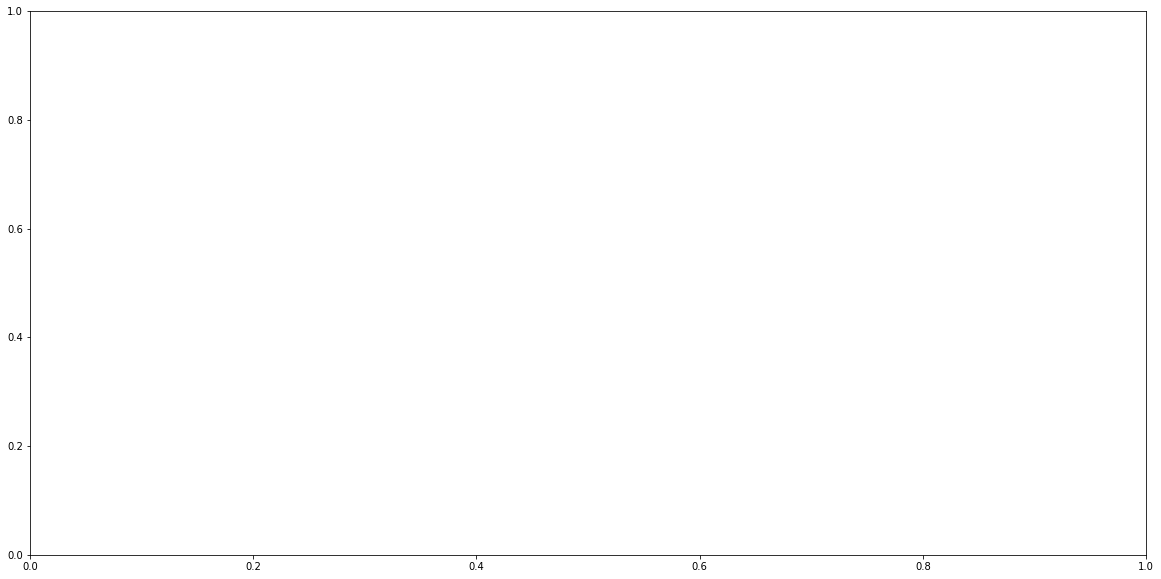

In [17]:
L = 20
N = 20
vmax = 1500.

hv = 2. * vmax / N
vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')

Mol = 32e-3

f_0 = np.zeros((L, N, N, N))
f_0[0, :, :, :] = F_m(vx, vy, vz, 400., 3e+25, Mol)
    
for i in range(1, L):
    f_0[i, :, :, :] = F_m(vx, vy, vz, 300., 2e+25, Mol)

f_l = lambda t: 0.
f = solver(f_0 = f_0, f_l = f_l, xl = 0., xr = 1., L = 20, Tau = 0.1, CFL = 0.5, a = 1., b = 0.5, vmax = 1500., N = 20)